In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)

In [2]:
df_train = pd.read_csv("../data/preprocessed/df_train001.csv")

---

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [5]:
# 데이터셋 생성
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [6]:
look_back = 100
X, y = create_dataset(df_train['평균기온'].values.reshape(-1,1), look_back)

In [7]:
train_size = int(len(df_train) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='huber')

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train.reshape(-1, look_back, 1),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test.reshape(-1, look_back, 1), y_test),
    callbacks=[early_stopping]
)



Epoch 1/100

504/504 [==============================] - 12s 21ms/step - loss: 4.3281 - val_loss: 1.6167
Epoch 2/100
504/504 [==============================] - 11s 21ms/step - loss: 1.2882 - val_loss: 1.2551
Epoch 3/100
504/504 [==============================] - 11s 21ms/step - loss: 1.1991 - val_loss: 1.2508
Epoch 4/100
504/504 [==============================] - 11s 23ms/step - loss: 1.1781 - val_loss: 1.2176
Epoch 5/100
504/504 [==============================] - 11s 22ms/step - loss: 1.1712 - val_loss: 1.1920
Epoch 6/100
504/504 [==============================] - 11s 22ms/step - loss: 1.1610 - val_loss: 1.1807
Epoch 7/100
504/504 [==============================] - 11s 21ms/step - loss: 1.1549 - val_loss: 1.1777
Epoch 8/100
504/504 [==============================] - 12s 23ms/step - loss: 1.1521 - val_loss: 1.1708
Epoch 9/100
504/504 [==============================] - 11s 22ms/step - loss: 1.1532 - val_loss: 1.1554
Epoch 10/100
504/504 [==============================] - 10s 21ms/step 

213/213 [==============================] - 1s 6ms/step


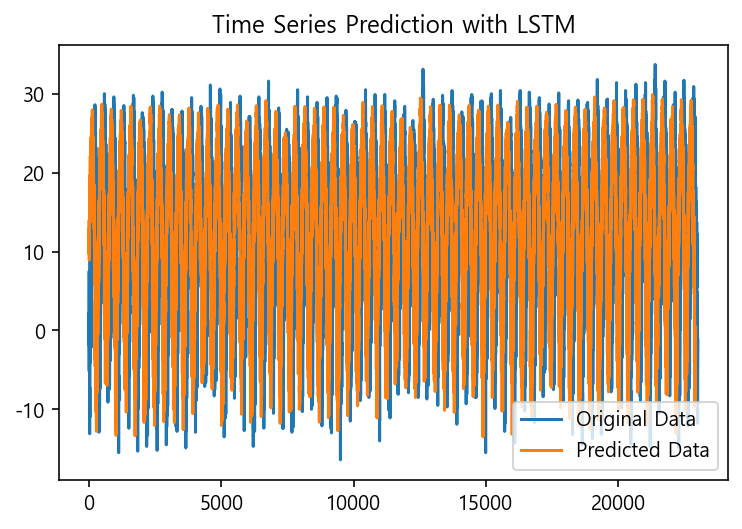

In [10]:
# 예측
train_predict = model.predict(X_train.reshape(-1, look_back, 1))
test_predict = model.predict(X_test.reshape(-1, look_back, 1))

plt.plot(df_train['평균기온'], label='Original Data')
plt.plot(np.concatenate([train_predict, test_predict]), label='Predicted Data')
plt.legend()
plt.title("Time Series Prediction with LSTM")
plt.show()

---

In [11]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [12]:
X = df_train['평균기온'].values

In [13]:
# 2023년 1월 1일 이후 1년치 값을 예측
num_days = len(sub_file)
predicted_values = []

for _ in range(num_days):
    # 현재까지 예측된 값으로 새로운 입력 시퀀스 생성
    last_sequence = X[-look_back:].reshape(1, -1, 1)
    predicted_value = model.predict(last_sequence)
    
    # 예측 결과를 저장
    predicted_values.append(predicted_value[0, 0])
    
    # 예측 결과를 데이터에 추가하여 다음 예측에 활용
    X = np.concatenate([X.reshape(-1,1), predicted_value], axis=0)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 35ms/step


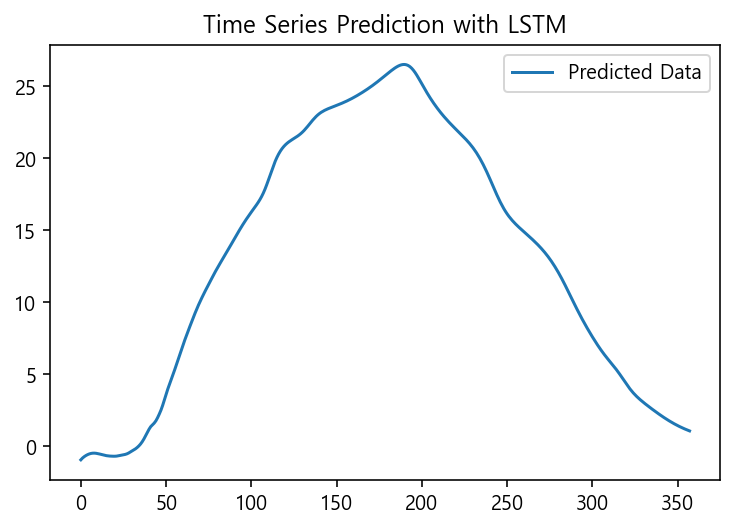

In [14]:
# 예측 결과 시각화
plt.plot(predicted_values, label='Predicted Data')
plt.legend()
plt.title("Time Series Prediction with LSTM")
plt.show()

In [15]:
sub_file['평균기온'] = predicted_values

<AxesSubplot:>

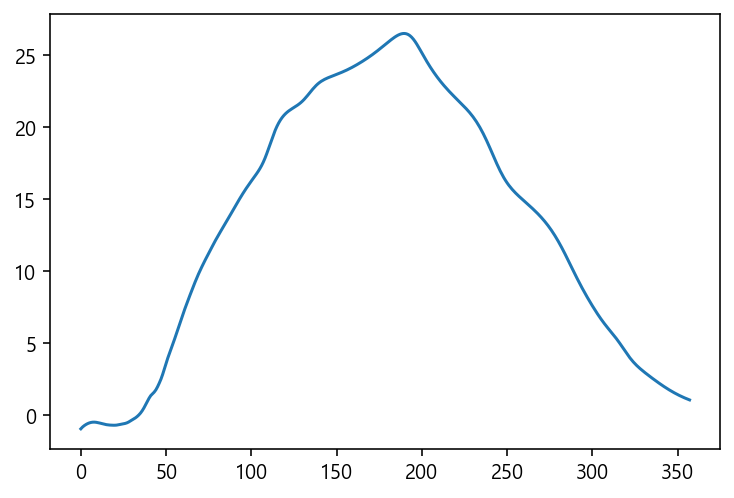

In [16]:
sub_file['평균기온'].plot()

In [17]:
sub_file.to_csv("../data/sub/010_LSTM_004.csv",
                index=False, encoding='utf-8')

---

In [18]:
import joblib

In [19]:
joblib.dump(model, '../model/LSTM_004.pkl')

['../model/LSTM_004.pkl']

In [20]:
loaded_model = joblib.load('../model/LSTM_004.pkl')